# Yelp Checkins Wrangling

In [249]:
%matplotlib inline

import pandas as pd
import datetime
import json
import numpy as np

import matplotlib.pyplot as plt


import seaborn as sns
sns.set()

DRY_RUN = False

In [250]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [251]:
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def time_marker(text=''):
    print('[{}] {}'.format(datetime.datetime.now().time(), text.title()))
    
def unpack(df, column, fillna=None):
    ret = None
    if fillna is None:
        ret = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems()))], axis=1)
        del ret[column]
    else:
        ret = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems())).fillna(fillna)], axis=1)
        del ret[column]
    return ret

# Load Checkins Data

In [252]:
time_marker(text='Loading Check Ins Data...')

data = pd.DataFrame()
source_data_file = '../source_data/checkin.json'

checkins_list = []
for line in open(source_data_file, 'r'):
    checkins_list.append(json.loads(line))

time_marker(text='creating dataframe...')
checkins_df = pd.DataFrame(checkins_list)
checkins_df.head(3)

[01:31:15.080757] Loading Check Ins Data...
[01:31:20.981621] Creating Dataframe...


,business_id,time
0,7KPBkxAOEtb3QeIL9PEErg,"{'Thursday': {'21:00': 4, '1:00': 1, '4:00': 1..."
1,kREVIrSBbtqBhIYkTccQUg,"{'Monday': {'13:00': 1}, 'Thursday': {'20:00':..."
2,tJRDll5yqpZwehenzE2cSg,"{'Monday': {'12:00': 1, '1:00': 1}, 'Saturday'..."


In [253]:
business_ids = checkins_df.business_id.to_frame()
business_ids.head(3)

,business_id
0,7KPBkxAOEtb3QeIL9PEErg
1,kREVIrSBbtqBhIYkTccQUg
2,tJRDll5yqpZwehenzE2cSg


# Unpack `time` column

In [254]:
time_marker(text='unpacking daily check in counts...')
checkins_df = unpack(checkins_df, 'time')
checkins_df.head(3)

[01:31:21.330759] Unpacking Daily Check In Counts...


,business_id,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,7KPBkxAOEtb3QeIL9PEErg,"{'16:00': 1, '14:00': 2, '10:00': 2, '23:00': ...","{'12:00': 1, '11:00': 1, '14:00': 1, '18:00': ...","{'21:00': 1, '23:00': 3, '18:00': 4, '10:00': ...","{'18:00': 1, '16:00': 1, '14:00': 1, '19:00': ...","{'21:00': 4, '1:00': 1, '4:00': 1, '2:00': 1, ...","{'18:00': 2, '12:00': 1, '13:00': 2, '16:00': ...","{'11:00': 2, '13:00': 2, '14:00': 1, '17:00': ..."
1,kREVIrSBbtqBhIYkTccQUg,NaN,{'13:00': 1},"{'21:00': 1, '16:00': 1}",{'19:00': 1},"{'20:00': 1, '13:00': 1}",NaN,{'17:00': 1}
2,tJRDll5yqpZwehenzE2cSg,NaN,"{'12:00': 1, '1:00': 1}",{'16:00': 1},NaN,{'0:00': 1},NaN,NaN


### If this is a dry run, only process the first 20 business records

In [255]:
if DRY_RUN:
    checkins_df = checkins_df[:2000].copy()

In [256]:
checkins_df

,business_id,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,7KPBkxAOEtb3QeIL9PEErg,"{'16:00': 1, '14:00': 2, '10:00': 2, '23:00': ...","{'12:00': 1, '11:00': 1, '14:00': 1, '18:00': ...","{'21:00': 1, '23:00': 3, '18:00': 4, '10:00': ...","{'18:00': 1, '16:00': 1, '14:00': 1, '19:00': ...","{'21:00': 4, '1:00': 1, '4:00': 1, '2:00': 1, ...","{'18:00': 2, '12:00': 1, '13:00': 2, '16:00': ...","{'11:00': 2, '13:00': 2, '14:00': 1, '17:00': ..."
1,kREVIrSBbtqBhIYkTccQUg,NaN,{'13:00': 1},"{'21:00': 1, '16:00': 1}",{'19:00': 1},"{'20:00': 1, '13:00': 1}",NaN,{'17:00': 1}
2,tJRDll5yqpZwehenzE2cSg,NaN,"{'12:00': 1, '1:00': 1}",{'16:00': 1},NaN,{'0:00': 1},NaN,NaN
3,nhZ1HGWD8lMErdn3FuWuTQ,"{'18:00': 1, '22:00': 2, '1:00': 1, '0:00': 1}","{'17:00': 1, '18:00': 1, '19:00': 1, '2:00': 1...","{'20:00': 1, '23:00': 2, '22:00': 3, '17:00': ...","{'18:00': 1, '17:00': 2, '22:00': 1, '0:00': 1...","{'3:00': 1, '0:00': 1, '20:00': 1, '21:00': 1,...","{'17:00': 1, '1:00': 1, '23:00': 3, '22:00': 3}","{'3:00': 1, '0:00': 1, '22:00': 1}"
4,vDoXZGE7p6xAkKQ0XQPvoA,NaN,NaN,{'23:00': 1},NaN,{'15:00': 1},NaN,NaN
5,8bY6M2yiWOF2ilfmGS34Fw,{'13:00': 1},NaN,{'11:00': 1},NaN,{'14:00': 1},NaN,NaN
6,zNVot5_XHsxwfKdiFjk_aA,"{'13:00': 1, '12:00': 1, '18:00': 1, '20:00': ...",{'0:00': 1},"{'21:00': 1, '20:00': 2, '22:00': 1, '17:00': ...","{'18:00': 1, '15:00': 1, '20:00': 1, '1:00': 1}","{'21:00': 1, '20:00': 2, '16:00': 1}","{'12:00': 1, '1:00': 1}","{'11:00': 1, '23:00': 1}"
7,BH0K6SxPnY3wTRB7tA27hQ,"{'17:00': 2, '22:00': 2, '23:00': 1, '0:00': 1}",NaN,"{'23:00': 3, '18:00': 3, '15:00': 1, '17:00': ...","{'19:00': 1, '23:00': 1, '22:00': 2, '0:00': 1...","{'22:00': 1, '23:00': 1, '19:00': 2, '17:00': 1}","{'17:00': 1, '1:00': 2, '22:00': 1, '23:00': 2}","{'17:00': 1, '0:00': 1, '23:00': 2}"
8,dPxL6P_Gp74CqSPuL59Srg,"{'16:00': 1, '13:00': 1, '11:00': 2, '23:00': 2}","{'10:00': 1, '23:00': 1}","{'20:00': 1, '19:00': 1, '12:00': 1, '14:00': ...","{'16:00': 8, '14:00': 3, '15:00': 3, '13:00': ...","{'22:00': 1, '18:00': 2, '17:00': 1, '15:00': ...","{'14:00': 1, '15:00': 1, '0:00': 2, '23:00': 1...","{'14:00': 2, '16:00': 1, '2:00': 1, '0:00': 1}"
9,aZbbt_RPKV8vUY7GWiEEyw,NaN,NaN,NaN,NaN,{'18:00': 1},NaN,NaN


# Unpack Hourly checkins from each Day Column

In [257]:
time_marker(text='splitting daily counts into hourly columns...')
chunks = []

for day in checkins_df.columns[1:]:
    data = checkins_df[day].copy().to_frame()

    # fill missing daily checkin dicts with empty dict
    data=data.applymap(lambda x: {} if pd.isnull(x) else x)

    # unpack dict to hourly
    chunk = data[day].apply(pd.Series)

    chunk.columns = [int(str(x).split(':')[0]) for x in chunk.columns]

    # fill in missing hours
    for n in range(0, 24, 1):
        if n not in chunk.columns:
            chunk[n] = np.nan
    chunk['day'] = day

    chunks.append(chunk)

checkins_df = pd.concat(chunks)
checkins_df.fillna(0, inplace=True)
checkins_df.head(3)

[01:31:22.171405] Splitting Daily Counts Into Hourly Columns...


,0,10,11,12,13,14,15,16,17,18,...,23,2,3,4,5,6,7,8,9,day
0,2.0,2.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Friday
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Friday
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Friday


# Append `dayofweek` to each column

In [258]:
checkins_df['dayofweek'] = checkins_df.apply(lambda row: day_labels.index(row.day.title()), axis=1)
checkins_df.drop('day', axis=1, inplace=True)

# Append `business_id` to each daily checkin row, left merge

In [259]:
time_marker(text='appending business_id columns to hourly records...')
checkins_clean = checkins_df.merge(business_ids, left_index=True, right_index=True, how='left')
checkins_clean.head(8)

[01:38:17.782217] Appending Business_Id Columns To Hourly Records...


,0,10,11,12,13,14,15,16,17,18,...,2,3,4,5,6,7,8,9,dayofweek,business_id
0,2.0,2.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,7KPBkxAOEtb3QeIL9PEErg
0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7KPBkxAOEtb3QeIL9PEErg
0,1.0,1.0,0.0,1.0,3.0,1.0,1.0,2.0,3.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,7KPBkxAOEtb3QeIL9PEErg
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,2.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,6,7KPBkxAOEtb3QeIL9PEErg
0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,7KPBkxAOEtb3QeIL9PEErg
0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,7KPBkxAOEtb3QeIL9PEErg
0,2.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,7KPBkxAOEtb3QeIL9PEErg
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,kREVIrSBbtqBhIYkTccQUg


# Cleanup and Reset Index

In [260]:
time_marker(text='cleaning up and reset index...')
checkins_clean.fillna(0, inplace=True)

checkins_clean.sort_values(['business_id', 'dayofweek'], inplace=True)

checkins_clean.reset_index(inplace=True, drop=True)
checkins_clean.head(8)

[01:38:18.415046] Cleaning Up And Reset Index...


,0,10,11,12,13,14,15,16,17,18,...,2,3,4,5,6,7,8,9,dayofweek,business_id
0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,--6MefnULPED_I942VcFNA
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,--6MefnULPED_I942VcFNA
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,--6MefnULPED_I942VcFNA
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3,--6MefnULPED_I942VcFNA
4,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,--6MefnULPED_I942VcFNA
5,3.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,--6MefnULPED_I942VcFNA
6,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6,--6MefnULPED_I942VcFNA
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,--7zmmkVg-IMGaXbuVd0SQ


# Group by `business_id`

In [261]:
t = checkins_clean.groupby(['business_id', 'dayofweek']).sum().unstack()

# relabel columns day_hour
corrected_columns = ['d{:d}_h{:d}'.format(day, hour)for hour in range(0, 24) for day in range(0, 7)]
t.columns = corrected_columns

# sort columns
sorted_columns = ['d{:d}_h{:d}'.format(day, hour) for day in range(0, 7) for hour in range(0, 24)]

# apply sort
t = t[sorted_columns]

# add sum column for sorting
t['total_checkins'] = t.apply(lambda row: row.sum(), axis=1)

t.sort_values(['total_checkins'], ascending=False, inplace=True)

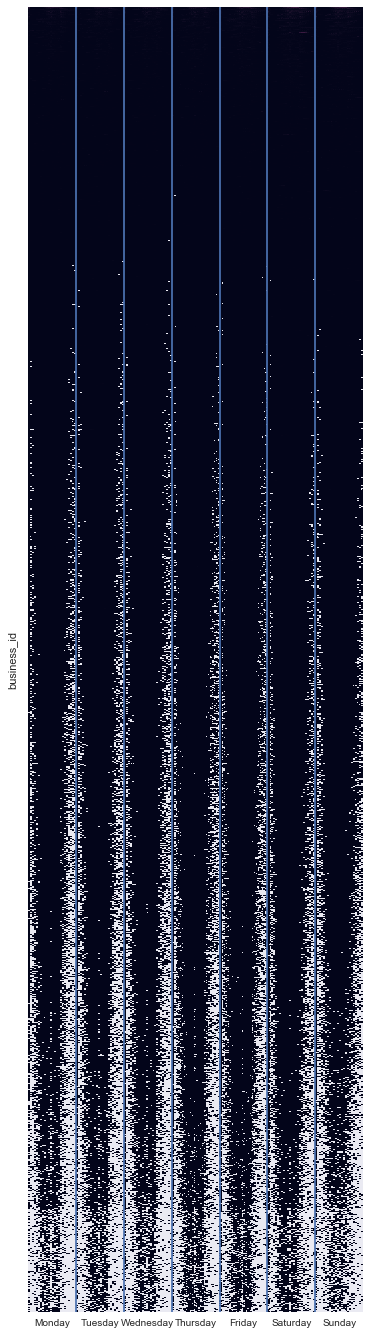

In [263]:
mask = t.iloc[:, :-1] == 0

plt.subplots(figsize=(6,24))
ax = sns.heatmap(t.iloc[:, :-1], mask=mask, cbar=False)
ax.set_xticks([x*24+12 for x in range(0, 7)])
ax.set_xticklabels(day_labels, rotation=0)

for x in [x*24 for x in range(1, 7)]:
    ax.axvline(x=x)

ax.set_yticklabels('')
plt.show()
plt.close()

# Write to File
<p>Split by day of week</p>

In [11]:
time_marker(text='Writing to files...')
day_count = len(checkins_clean.day.unique())
for i, day in enumerate(checkins_clean.day.unique()):
    df = checkins_clean[checkins_clean.day == day].copy()
    df.reset_index(inplace=True, drop=True)

    file_name = '../clean_data/checkins/{}_{}_checkins_clean.csv'.format(str(i).zfill(2), day.lower())
    time_marker(text='Writing {} records file...'.format(day))
    if DRY_RUN:
        pass
    else:
        df.to_csv(file_name, encoding='utf-8')

[19:16:54.636819] Writing To Files...
[19:16:54.963056] Writing Friday Records File...
[19:16:59.203796] Writing Monday Records File...
[19:17:03.277101] Writing Saturday Records File...
[19:17:07.517902] Writing Sunday Records File...
[19:17:12.261991] Writing Thursday Records File...
[19:17:17.323008] Writing Tuesday Records File...
[19:17:21.466190] Writing Wednesday Records File...
